In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
import torchvision.utils as vutils
import math
import random
import numpy as np
import pandas as pd
import cv2
import os
import glob
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
# Data directory
PATH_DIR = '/content/drive/MyDrive/CV-Project/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent or random noise vector
nz = 512

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for discriminator and generator optimizers
lr_GAN = 0.0002

# Learning rate for input encoder optimizer
lr_enc = 0.0006

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# INPUT ENCODER CONFIGS
# Number of transformer blocks
num_blocks = 9

# Word embedding length
d_model = 512

# Number of heads in multi-head self attention
num_heads = 8

# Attention padding mask fill value
mask_val = -1e10

# Transformer block output length
d_ff = 4 * d_model

# Dropout rate
dropout = 0.1

Data Preparation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, imgpath, txtpath):
      '''
      Takes as input the path to files containing captions in each line.
      Stores the text data in a member variable Y
      '''
      # opening the files and storing their contents in lists
      image_list = []
      listOfImgFiles = glob.glob(imgpath + '*.jpg')
      listOfImgFiles = listOfImgFiles
      for imgfile in listOfImgFiles:
        img = cv2.imread(imgfile)
        resized_img = cv2.resize(img, (image_size, image_size))
        image_list.append(resized_img)

      caption_list = []
      listOfTxtFiles = list()
      for (dirpath, dirnames, filenames) in os.walk(txtpath):
        listOfTxtFiles += [os.path.join(dirpath, file) for file in filenames]
        listOfTxtFiles = listOfTxtFiles
      for txtfile in listOfTxtFiles:
        caption_list.append(self.get_caption(txtfile))

      # store them in member variables
      self.X = image_list
      self.Y = caption_list

    def get_caption(self, filename):
      with open(filename) as f:
          lines = f.readlines()
          str_list = list(filter(None, lines))
      return self.preprocess(random.choice(str_list))

    def preprocess(self, text):
      text_pp = text.lower().replace(',', ' ').replace(';', ' ').replace('.', '').strip()
      return text_pp
    
    def __len__(self):
      return len(self.Y)
   
    def __getitem__(self, index):
      '''
      Returns the text present at the specified index of the list.
      '''
      return self.X[index], self.Y[index]

In [ ]:
# create a dataset object
dset = CustomDataset(PATH_DIR + 'flowers-images/', PATH_DIR + 'flowers-captions/')

# wrap it around a dataloader
data_loader = DataLoader(dset, batch_size = batch_size, num_workers = workers)

In [ ]:
i = 1
for X_batch, Y_batch in data_loader:
  print('batch ' + str(i), 'X shape : ', X_batch.shape, len(Y_batch))
  i += 1

batch 1 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 2 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 3 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 4 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 5 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 6 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 7 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 8 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 9 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 10 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 11 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 12 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 13 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 14 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 15 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 16 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 17 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 18 X shape :  torch.Size([128, 64, 64, 3]) 128
batch 19 X shape :  torch.Size([128, 64, 64, 3]) 128
ba

Build Vocabulary

In [ ]:
sent_lengths = []
text_data = []
for _, Y_batch in data_loader:
  for sent in Y_batch:
    words = sent.split()
    sent_lengths.append(len(words))
    for word in words:
      text_data.append(word)

In [ ]:
MAX_LEN = max(sent_lengths)
print('Max caption length : ', MAX_LEN)

Max caption length :  56


In [ ]:
PAD = '<pad>'
UNK = '<unk>'
vocab = Counter([tok for tok in text_data])
assert not PAD in vocab  
assert not UNK in vocab  
vocab[PAD] = 9999999  # PAD will get index 0
vocab[UNK] = 9999998  # UNK will get index 1
vocab_size = 10000 
vocab = [word for word, _ in vocab.most_common(vocab_size)]

VOCAB_LEN = len(vocab)
print('Vocab size: {} (with PAD and UNK added)'.format(VOCAB_LEN))
print('vocab[0]:', vocab[0])
print('vocab[1]:', vocab[1])
print('vocab[1567]:', vocab[1567])

Vocab size: 2084 (with PAD and UNK added)
vocab[0]: <pad>
vocab[1]: <unk>
vocab[1567]: concentrated


Data Splits

In [ ]:
# 80-10-10 train-dev-test split

shuffle_dataset = True
random_seed= 42
dataset_size = len(data_loader.dataset)
indices = list(range(dataset_size))
split1 = int(np.floor(0.2 * dataset_size))
split2 = int(np.floor(0.1 * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, dev_indices, test_indices = indices[split1:], indices[split2:split1], indices[:split2]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
dev_sampler = SubsetRandomSampler(dev_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(data_loader.dataset, batch_size=128, sampler=train_sampler)
dev_loader = DataLoader(data_loader.dataset, batch_size=128, sampler=dev_sampler)
test_loader = DataLoader(data_loader.dataset, batch_size=128, sampler=test_sampler)

In [ ]:
print('Dev split : ')
i = 1
for X_batch, Y_batch in dev_loader:
  print('X Y batch', str(i), ' : ', X_batch.shape, len(Y_batch))
  i += 1

Dev split : 
X Y batch 1  :  torch.Size([128, 64, 64, 3]) 128
X Y batch 2  :  torch.Size([128, 64, 64, 3]) 128
X Y batch 3  :  torch.Size([128, 64, 64, 3]) 128
X Y batch 4  :  torch.Size([128, 64, 64, 3]) 128
X Y batch 5  :  torch.Size([128, 64, 64, 3]) 128
X Y batch 6  :  torch.Size([128, 64, 64, 3]) 128
X Y batch 7  :  torch.Size([51, 64, 64, 3]) 51


Image Encoder

In [ ]:
# Residual block
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, prob=0.):
    super(block, self).__init__()
    self.expansion = 4  # number of channels after a block is always 4 times of what it was when it entered
    
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
    self.dropout = nn.Dropout2d(prob)
    self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample  # to preserve shape of identity mapping

  def forward(self, x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.dropout(x)

    if self.identity_downsample is not None:
      # reshaping x to be same shape as f(x)
      identity = self.identity_downsample(identity)
    x += identity
    x = self.relu(x)
    return x


# ResNet50 architecture
class ResNet(nn.Module):
  def __init__(self, dropout=0.):
    super().__init__()
    layers = [3, 4, 6, 3]   # number of times we use the Residual block in each stage
    image_channels = nc
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layers
    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)
    
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * 4, MAX_LEN)

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels * 4:   # condition for when to reshape identity mapping
      identity_downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels * 4))

    # block 1
    layers.append(block(self.in_channels, out_channels, identity_downsample, stride, prob=dropout))
    self.in_channels = out_channels * 4

    # remaining blocks
    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels, prob=0.5))

    return nn.Sequential(*layers)
  
  
  def forward(self, images):
    """
    Compute the encodings for a mini-batch of training images.
    
    Inputs:
    - images: A Tensor of shape (batch_size, channels, height, width)
      containing a mini-batch of training images.
    
    Returns:
    - out: A Tensor of shape (batch_size, MAX_LEN)
      containing final image encoding.
    """
    images = self.conv1(images)
    images = self.bn1(images)
    images = self.relu(images)
    images = self.maxpool(images)

    images = self.layer1(images)
    images = self.layer2(images)
    images = self.layer3(images)
    images = self.layer4(images)

    images = self.avgpool(images)
    images = images.reshape(images.shape[0], -1)
    out = self.fc(images)

    return out

Text Encoder

In [ ]:
class MultiHeadCausalSelfAttention(nn.Module):
  
  def __init__(self, d_model, num_heads, dropout=0.):
    super().__init__()
    
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    self.d_model = d_model
    self.num_heads = num_heads
    self.dropout = nn.Dropout(dropout)
    
    # The weight matrices of all heads are concatenated together
    self.proj_q = nn.Linear(d_model, d_model, bias=False)
    self.proj_k = nn.Linear(d_model, d_model, bias=False)
    self.proj_v = nn.Linear(d_model, d_model, bias=False)
    
    self.proj_o = nn.Linear(d_model, d_model, bias=False)
  
  
  def forward(self, input, input_mask):
    """
    Inputs:
    - input: A Tensor of shape (batch_size, MAX_LEN, d_model)
      containing sequences of embeddings.
    - input_mask: A LongTensor of shape (batch_size, MAX_LEN)
      for masking out the padding tokens.
    
    Returns:
    - output: A Tensor of shape (batch_size, MAX_LEN, d_model)
      containing the updated embeddings.
    """
    batch_size = input.shape[0]
    seq_len = input.shape[1]
    hd = self.d_model // self.num_heads
    
    Q = self.proj_q(input)
    K = self.proj_k(input)
    V = self.proj_v(input)
    
    Q = Q.view(batch_size, -1, self.num_heads, hd).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.num_heads, hd).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.num_heads, hd).permute(0, 2, 1, 3)
    
    pre_attention = torch.matmul(Q, K.permute(0, 1, 3, 2)) / torch.sqrt(torch.FloatTensor([hd]).cuda())
    pad_mask = input_mask.unsqueeze(1).unsqueeze(1)
    pre_attention = pre_attention.masked_fill(pad_mask == 0, mask_val)
    attention = torch.softmax(pre_attention, dim = -1)
    attention = self.dropout(attention)  

    output = torch.matmul(attention, V)
    output = output.permute(0, 2, 1, 3).contiguous() 
    output = output.view(batch_size, -1, self.d_model)
    output = self.proj_o(output)
    
    return output

In [ ]:
class TransformerBlock(nn.Module):
  
  def __init__(self, d_model, num_heads, d_ff, dropout=0.):
    super().__init__()
    #########################################################################
    # Set up the Transformer block components.                              #
    #########################################################################
    self.mhcsa = MultiHeadCausalSelfAttention(d_model, num_heads, dropout)
    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
    self.feedforward = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, d_model))
  
  
  def forward(self, input, input_mask):
    """
    Inputs:
    - input: A Tensor of shape (batch_size, MAX_LEN, d_model)
      containing sequences of embeddings.
    - input_mask: A LongTensor of shape (batch_size, MAX_LEN)
      for masking out the padding tokens.
    
    Returns:
    - output: A Tensor of shape (batch_size, MAX_LEN, d_model)
      containing the updated embeddings.
    """
    x = self.mhcsa(input, input_mask)
    x = self.dropout(x)
    x = self.layer_norm(input + x)
    output = self.feedforward(x)
    output = self.dropout(output)
    output = self.layer_norm(output + x)
    
    return output

In [ ]:
class PositionalEncoding(nn.Module):
  
  def __init__(self, max_len, d_model, dropout=0.):
    super().__init__()
    
    self.dropout = nn.Dropout(dropout)
    
    #########################################################################
    # Precompute the positional encodings.                                  #
    #########################################################################`
    frequency = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.) / d_model))  # Using different frequency for each d_model
    positions = torch.arange(0, max_len).unsqueeze(1)
    wave = torch.zeros(max_len, d_model)
    wave[:, 0::2] = torch.sin(frequency * positions)
    wave[:, 1::2] = torch.cos(frequency * positions)
    self.register_buffer('wave', wave.unsqueeze(0))  # (1, max_len, d_model)
    self.d_model = d_model
    
  
  def forward(self, input):
    """
    Inputs:
    - input: A Tensor of shape (batch_size, MAX_LEN, d_model)
      containing sequences of word embeddings.
    
    Returns:
    - output: A Tensor of shape (batch_size, MAX_LEN, d_model)
      containing dropout(word embeddings + positional encodings).
    """
    position_encoding = self.wave[:, :input.size(-2), :]
    x = input * math.sqrt(self.d_model)
    output = self.dropout(x + position_encoding)
    
    return output

In [ ]:
class Transformer(nn.Module):
  
  def __init__(self, num_blocks, vocab_size, max_len, d_model, num_heads, d_ff, dropout=0.):
    super().__init__()
    #########################################################################
    # Set up the Transformer components.                                    #
    #########################################################################
    self.embed = torch.nn.Embedding(vocab_size, d_model)
    self.pos = PositionalEncoding(max_len, d_model, dropout)
    self.dropout = nn.Dropout(dropout)
    self.transformers = nn.ModuleList([TransformerBlock(d_model, num_heads, d_ff, dropout) 
                                     for _ in range(num_blocks)])
    self.linear = nn.Linear(d_model, vocab_size, bias=False)
    self.linear.weight = self.embed.weight  # weight sharing between linear and embedding layers
    self.embed.weight.requires_grad=True    # learnable embedding layer
  
  
  def forward(self, input_text, input_mask):
    """
    Inputs:
    - input_text: A LongTensor of shape (batch_size, MAX_LEN)
      containing a mini-batch of sentences padded to `MAX_LEN`.
      Each token is represented by its index in the vocabulary.
    - input_mask: A LongTensor of shape (batch_size, MAX_LEN)
      for masking out the padding tokens.
    
    Returns:
    - out: A Tensor of shape (batch_size, MAX_LEN, VOCAB_LEN)
      containing final text encoding.
    """
    embedded = self.embed(input_text)
    pos_embedded = self.pos(embedded)
    trg = self.dropout(pos_embedded)
    for layer in self.transformers:
      trg = layer(trg, input_mask)
    out = self.linear(trg)
    
    return out

Joint text-image encoder

In [ ]:
class InputEncoder(nn.Module):
  
  def __init__(self, num_blocks, vocab_size, max_len, d_model, num_heads, d_ff, dropout=0.):
    super().__init__()
    
    self.textencoder = Transformer(num_blocks, vocab_size, max_len, d_model, num_heads, d_ff, dropout)
    self.imageencoder = ResNet(dropout)
    
  
  def forward(self, input_img, input_text, input_mask):
    """
    Perform next word prediction and compute loss.
    
    Inputs:
    - input_img: A LongTensor of shape (batch_size, channels, height, width)
      containing a mini-batch of training images.
      Each token is represented by its index in the vocabulary.
    - input_text: A LongTensor of shape (batch_size, MAX_LEN)
      containing a mini-batch of sentences padded to `MAX_LEN`.
      Each token is represented by its index in the vocabulary.
    - input_mask: A LongTensor of shape (batch_size, MAX_LEN)
      for masking out the padding tokens.
    
    Returns:
    - loss: A PyTorch scalar containing the embedding loss for the mini-batch.
    - text_encoding: A Tensor of shape (batch_size, MAX_LEN)
      containing final input text encoding.
    """
    # encode text
    text_encoding = self.textencoder(input_text, input_mask)
    text_encoding = torch.mean(text_encoding, dim=2)

    # encode image
    image_encoding = self.imageencoder(input_img)

    # compute embedding loss
    loss = torch.nn.MSELoss()(text_encoding, image_encoding)
    
    return loss, text_encoding

  def predict(self, input_text, input_mask):
    """
    Perform next word prediction and compute loss.
    
    Inputs:
    - input_text: A LongTensor of shape (batch_size, MAX_LEN)
      containing a mini-batch of sentences padded to `MAX_LEN`.
      Each token is represented by its index in the vocabulary.
    - input_mask: A LongTensor of shape (batch_size, MAX_LEN)
      for masking out the padding tokens.
    
    Returns:
    - text_encoding: A Tensor of shape (batch_size, MAX_LEN)
      containing final input text encoding.
    """
    text_encoding = self.textencoder(input_text, input_mask)
    text_encoding = torch.mean(text_encoding, dim=2)

    return text_encoding

DC-GAN 

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz + MAX_LEN, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# create joint encoder model

enc = InputEncoder(num_blocks=num_blocks, vocab_size=VOCAB_LEN, max_len=MAX_LEN, d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout)
enc.cuda()

InputEncoder(
  (textencoder): Transformer(
    (embed): Embedding(2084, 512)
    (pos): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformers): ModuleList(
      (0): TransformerBlock(
        (mhcsa): MultiHeadCausalSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (proj_q): Linear(in_features=512, out_features=512, bias=False)
          (proj_k): Linear(in_features=512, out_features=512, bias=False)
          (proj_v): Linear(in_features=512, out_features=512, bias=False)
          (proj_o): Linear(in_features=512, out_features=512, bias=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (feedforward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# create the Generator
netG = Generator(ngpu)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

netG.cuda()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(568, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
# create the Discriminator
netD = Discriminator(ngpu)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

netD.cuda()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz + MAX_LEN, 1, 1).cuda()

# establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# setup Adam optimizers for joint encoder, discriminator and generator
optimizer_enc = optim.Adam(enc.parameters(), lr=lr_enc, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr_GAN, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_GAN, betas=(beta1, 0.999))

In [ ]:
# this function returns input tensor and padding mask from an input batch of text

def get_text_input(Y_batch):
  text = torch.zeros((len(Y_batch), MAX_LEN), dtype=torch.int64)
  for sent_idx, sent in enumerate(Y_batch):
    words = sent.split()
    for idx, word in enumerate(words):
      if word in vocab:
        text[sent_idx][idx] = vocab.index(word)
      else:
        text[sent_idx][idx] = 1
  mask = (text != 0)

  return text.cuda(), mask.cuda()

Training

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
enc_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, (X_batch, Y_batch) in enumerate(train_loader):
        X_img = X_batch.float().permute(0, 3, 1, 2).cuda()
        Y_text, Y_mask = get_text_input(Y_batch)
        
        # Generate text embeddings
        embedding_loss, embedding = enc.forward(X_img, Y_text, Y_mask)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = X_img.cpu()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu.cuda()).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label.cuda())
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1).cuda()
        # Concat noise and embedding vectors
        input = torch.cat([noise, embedding.unsqueeze(-1).unsqueeze(-1)], dim=1)     
        # Generate fake image batch with G
        fake = netG(input)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label.cuda())
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label.cuda())
        # add MSE loss between text and image encodings
        errG += embedding_loss
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Update joint encoder
        optimizer_enc.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), embedding_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        enc_losses.append(embedding_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/40][0/52]	Loss_D: 1.6139	Loss_G: 5.5160	Loss_enc: 0.8113	D(x): 0.4976	D(G(z)): 0.5014 / 0.0124
[0/40][50/52]	Loss_D: 0.7913	Loss_G: 5.6649	Loss_enc: 1.9498	D(x): 0.6887	D(G(z)): 0.0649 / 0.0275
[1/40][0/52]	Loss_D: 0.8315	Loss_G: 13.4920	Loss_enc: 0.5530	D(x): 0.6362	D(G(z)): 0.0008 / 0.0000
[1/40][50/52]	Loss_D: 1.4885	Loss_G: 8.1102	Loss_enc: 3.0590	D(x): 0.5807	D(G(z)): 0.2190 / 0.0067
[2/40][0/52]	Loss_D: 1.4609	Loss_G: 8.7625	Loss_enc: 1.9694	D(x): 0.6536	D(G(z)): 0.4605 / 0.0012
[2/40][50/52]	Loss_D: 0.2805	Loss_G: 35.9232	Loss_enc: 25.5806	D(x): 0.8720	D(G(z)): 0.0043 / 0.0000
[3/40][0/52]	Loss_D: 2.1264	Loss_G: 40.3514	Loss_enc: 24.6078	D(x): 0.8541	D(G(z)): 0.8275 / 0.0000
[3/40][50/52]	Loss_D: 0.3344	Loss_G: 17.4106	Loss_enc: 12.7753	D(x): 0.8078	D(G(z)): 0.0472 / 0.0098
[4/40][0/52]	Loss_D: 0.1407	Loss_G: 14.0296	Loss_enc: 8.0303	D(x): 0.9309	D(G(z)): 0.0528 / 0.0025
[4/40][50/52]	Loss_D: 0.2729	Loss_G: 20.5882	Loss_enc: 15.5473	D(x): 0.8811	D(G(

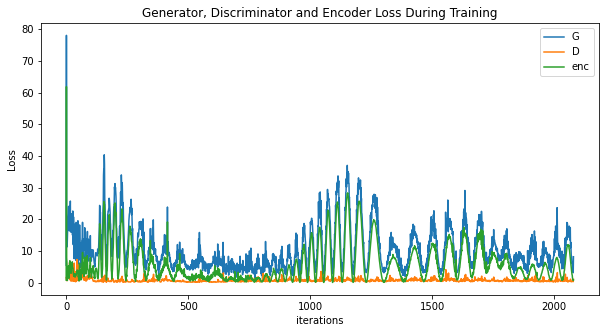

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator, Discriminator and Encoder Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(enc_losses,label="enc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(enc, PATH_DIR + 'flowers-trained-models/encoder')
torch.save(netG, PATH_DIR + 'flowers-trained-models/generator')
torch.save(netD, PATH_DIR + 'flowers-trained-models/discriminator')

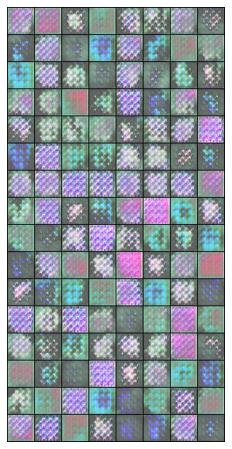

In [ ]:
# visualize the training progression of G on the fixed_noise batch after every epoch of training

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Inference for Model Tuning

In [ ]:
# Image Generation on validation set

print("Starting generation on Dev set...")
# For each batch in the dev_loader
for i, (X_batch, Y_batch) in enumerate(dev_loader):
  X_img = X_batch.float().permute(0, 3, 1, 2).cuda()
  Y_text, Y_mask = get_text_input(Y_batch)
  
  # Generate text encodings
  embedding = enc.predict(Y_text, Y_mask)
  # Generate batch of latent vectors
  noise = torch.randn(embedding.shape[0], nz, 1, 1).cuda()
  # Concat noise and embedding vectors
  input = torch.cat([noise, embedding.unsqueeze(-1).unsqueeze(-1)], dim=1)   
    
  # Generate fake image batch with G
  fake = netG(input).detach().cpu()
  for j in range(fake.shape[0]):
    caption = Y_batch[j].replace('\'', '').replace(' ', '_').replace('/', '_').replace('-', '_')
    save_image(fake[j], PATH_DIR + 'flowers-generated-dev/' + caption + '.jpg')
    
print("Saved generated images for dev set.")

Starting generation on Dev set...
Saved generated images for dev set.


Inference on held-out test set

In [ ]:
# Image Generation on test set

print("Starting generation on Test set...")
# For each batch in the test_loader
for i, (X_batch, Y_batch) in enumerate(test_loader):
  X_img = X_batch.float().permute(0, 3, 1, 2).cuda()
  Y_text, Y_mask = get_text_input(Y_batch)
  
  # Generate text encodings
  embedding = enc.predict(Y_text, Y_mask)
  # Generate batch of latent vectors
  noise = torch.randn(embedding.shape[0], nz, 1, 1).cuda()
  # Concat noise and embedding vectors
  input = torch.cat([noise, embedding.unsqueeze(-1).unsqueeze(-1)], dim=1)   
    
  # Generate fake image batch with G
  fake = netG(input).detach().cpu()
  for j in range(fake.shape[0]):
    caption = Y_batch[j].replace('\'', '').replace(' ', '_').replace('/', '_').replace('-', '_')
    save_image(fake[j], PATH_DIR + 'flowers-generated-test/' + caption + '.jpg')
    
print("Saved generated images for test set.")

Starting generation on Test set...
Saved generated images for test set.
